# MEADS/GHMC-based cross-validation proof of concept

In this notebook we retain all the draws, so this is slow. The model is a gaussian LR and we're using 5-fold CV.

In [1]:
from typing import Callable, Dict, NamedTuple, Optional, Union

import jax
import jax.numpy as jnp

import blackjax.adaptation as adaptation
import blackjax.mcmc as mcmc
import blackjax.sgmcmc as sgmcmc
import blackjax.smc as smc
import blackjax.vi as vi
from blackjax.base import AdaptationAlgorithm, MCMCSamplingAlgorithm, VIAlgorithm
from blackjax.progress_bar import progress_bar_scan
from blackjax.types import Array, PRNGKey, PyTree
from blackjax.kernels import ghmc

import blackjax
import jax
import chex
import jax.numpy as jnp
import arviz as az
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
import matplotlib.pyplot as plt
from typing import NamedTuple
from jax.tree_util import tree_map, tree_structure, tree_flatten, tree_unflatten
from jax.scipy.special import logsumexp
import pandas as pd

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

The following code is a fork of the [MEADS kernel in Blackjax](https://github.com/blackjax-devs/blackjax/blob/bab42d809b48492f2cbc06471497cefbbf8a90f8/blackjax/kernels.py#L750). Blackjax is [Apache 2.0 licensed](https://github.com/blackjax-devs/blackjax/blob/main/LICENSE).

In [2]:
def run_meads(
    logjoint_density_fn: Callable,
    num_chains: int,
    prng_key: PRNGKey,
    positions: PyTree,
    num_steps: int = 1000,
    retain_draws: bool = False,
) -> AdaptationAlgorithm:
    """Adapt the parameters of the Generalized HMC algorithm.

    See docco at https://github.com/blackjax-devs/blackjax/blob/bab42d809b48492f2cbc06471497cefbbf8a90f8/blackjax/kernels.py#L750

    Parameters
    ----------
    logdensity_fn
        The log density probability density function from which we wish to sample.
    num_chains
        Number of chains used for cross-chain warm-up training.
    rng_key: PRNGKey
        Random number generator key.
    positions: PyTree
        Initial position of the chains.
    num_steps: int
        Number of steps to run the adaptation for.
    retain_draws: bool
        Whether to retain the draws from the adaptation phase.

    Returns
    -------
    Last states of the chains and the parameters of the Generalized HMC algorithm.

    """
    step_fn = ghmc.kernel()
    init, update = adaptation.meads.base()
    batch_init = jax.vmap(lambda r, p: ghmc.init(r, p, logjoint_density_fn))

    def one_step_offline(carry, rng_key):
        states, adaptation_state = carry

        def kernel(rng_key, state):
            return step_fn(
                rng_key,
                state,
                logjoint_density_fn,
                adaptation_state.step_size,
                adaptation_state.position_sigma,
                adaptation_state.alpha,
                adaptation_state.delta,
            )

        keys = jax.random.split(rng_key, num_chains)
        new_states, info = jax.vmap(kernel)(keys, states)
        new_adaptation_state = update(
            adaptation_state, new_states.position, new_states.potential_energy_grad
        )

        return (new_states, new_adaptation_state), (
            new_states,
            info,
            new_adaptation_state,
        )

    def one_step_online(carry, rng_key):
        states, adaptation_state = carry

        def kernel(rng_key, state):
            return step_fn(
                rng_key,
                state,
                logjoint_density_fn,
                adaptation_state.step_size,
                adaptation_state.position_sigma,
                adaptation_state.alpha,
                adaptation_state.delta,
            )

        keys = jax.random.split(rng_key, num_chains)
        new_states, info = jax.vmap(kernel)(keys, states)
        new_adaptation_state = update(
            adaptation_state, new_states.position, new_states.potential_energy_grad
        )

        return (new_states, new_adaptation_state), None

    key_init, key_adapt = jax.random.split(prng_key)

    rng_keys = jax.random.split(key_init, num_chains)
    init_states = batch_init(rng_keys, positions)
    init_adaptation_state = init(positions, init_states.potential_energy_grad)

    keys = jax.random.split(key_adapt, num_steps)
    (last_states, last_adaptation_state), _ = jax.lax.scan(
        one_step_online, (init_states, init_adaptation_state), keys
    )

    parameters = {
        "step_size": last_adaptation_state.step_size,
        "momentum_inverse_scale": last_adaptation_state.position_sigma,
        "alpha": last_adaptation_state.alpha,
        "delta": last_adaptation_state.delta,
    }

    return last_states, parameters


## Model definition

Gaussian linear regression

In [3]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [4]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable.

In [5]:
# y = y.at[23].set(75.0)  # outlier

In [6]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int = -1) -> chex.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set, use -1 for all data.
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    mask = 1.0 * ((jnp.arange(N) % 5) != fold_id)
    ll_contribs = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (mask * ll_contribs).sum()
    return lp + ll


# within-sample density log p(y|theta)
def log_p(theta):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    esq = ((X @ theta.beta - y) ** 2).sum()
    return -0.5 * (
        N * jnp.log(2 * jnp.pi)
        + N * jnp.log(sigsq)
        + esq/sigsq
    )


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = 1.0 * ((jnp.arange(N) % 5) == fold_id)
    npred = pred_mask.sum()
    esq = ((X @ theta.beta - y) ** 2) * pred_mask
    return -0.5 * (
        npred * jnp.log(2 * jnp.pi)
        + npred * jnp.log(sigsq)
        + esq.sum()/sigsq
    )


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

### Online algo implementation

In this notebook, we cheat horribly by performing online inference but *also* keeping all the draws, just for validation purposes.

In [7]:
# stack arrays in pytrees
def tree_stack(trees):
    return tree_map(lambda *xs: jnp.stack(xs, axis=0), *trees)

# stack arrays in pytrees
def tree_concat(trees):
    return tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *trees)

In [8]:
class WelfordState(NamedTuple):
    K: chex.Array  # central estimate of data
    Ex: chex.Array  # sum of deviations from K
    Eax: chex.Array  # sum of absolute deviations from K
    Ex2: chex.Array  # sum of squared deviations from K
    n: chex.Array  # number of data points


def welford_init(K: chex.Array) -> WelfordState:
  """Initialize new welford algorithm state.
  
  Args:
    K: estimated mean value of data. Same shape as data.
  """
  return WelfordState(K=K*1., Ex=K*0., Eax=K*0., Ex2=K*0., n=K*0)

def welford_add(x: chex.Array, state: WelfordState) -> WelfordState:
  return WelfordState(
    K=state.K,
    Ex=state.Ex + x - state.K,
    Eax=state.Eax + jnp.abs(x - state.K),
    Ex2=state.Ex2 + (x - state.K)**2,
    n=state.n + 1)

def welford_mean(state: WelfordState):
  return state.K + state.Ex / state.n

def welford_mad(state: WelfordState):
  return state.Eax / state.n

def welford_var(state: WelfordState):
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)


class ExtendedState(NamedTuple):
    state: blackjax.mcmc.ghmc.GHMCState  # current HMC state
    rng_key: chex.Array  # current random seed
    pred_ws: WelfordState  # accumulator for log predictive
    log_pred_mean: float  # log of mean predictive
    param_ws: WelfordState  # accumulator for parameters
    divergences: chex.Array  # divergence counts (int array)

    def diagnostics(self) -> None:
        """Summarize the state of this object."""
        # TODO: add mean and s.e. of the parameters
        rhats = [(n, rhat(v)) for n, v in zip(self.param_ws._fields, self.param_ws)]
        predrh, predsrh = rhat(self.pred_ws)
        status = [
            f'       Summary: {int(jnp.sum(self.pred_ws.n[0,:]))} draws * {self.state.position[0].shape[0]} chains',
        ]
        param = [f'{n: >9} Rhat: {v} ({desc})' for n, (rh, frh) in rhats for v, desc in [(rh, 'regular'), (frh, 'tail')]]
        lines = status + param + [
            f"    pred. Rhat: {predrh:.4f}  tail: {predsrh:.4f}",
            f"   divergences: {int(jnp.sum(self.divergences))}"
        ]
        print('\n'.join(lines))


# single chain inference loop we will run in parallel using vmap
def offline_inference_loop(rng_key, kernel, initial_state, num_samples, log_pred, theta_center):
    log_half_samp = jnp.log(0.5 * num_samples + 1)  # +1 for initialization
    def one_mcmc_step(ext_state, idx):
        i_key, carry_key = jax.random.split(ext_state.rng_key)
        chain_state, chain_info = kernel(i_key, ext_state.state)
        elpd_contrib = log_pred(chain_state.position) - log_half_samp  # contrib to mean log predictive
        carry_log_pred_mean = ext_state.log_pred_mean + jnp.log1p(jnp.exp(elpd_contrib - ext_state.log_pred_mean))
        div_count = ext_state.divergences +  1.0 * chain_info.is_divergent
        carry_pred_ws = welford_add(elpd_contrib, ext_state.pred_ws)
        carry_param_ws = tree_map(welford_add, chain_state.position, ext_state.param_ws)
        carry_state = ExtendedState(
          state=chain_state,
          rng_key=carry_key,
          pred_ws=carry_pred_ws,
          log_pred_mean=carry_log_pred_mean,
          param_ws=carry_param_ws,
          divergences=div_count)
        return carry_state, chain_state
    # first half of chain
    initial_state_1h = ExtendedState(
        initial_state,
        rng_key,
        pred_ws=welford_init(log_pred(theta_center)),
        log_pred_mean = log_pred(theta_center) - log_half_samp,
        param_ws=tree_map(welford_init, theta_center),
        divergences=0)
    carry_state_1h, states_1h = jax.lax.scan(one_mcmc_step, initial_state_1h, jnp.arange(0, num_samples//2))
    # second half of chain - continue at same point but accumulate into new welford states
    initial_state_2h = ExtendedState(
        carry_state_1h.state,
        carry_state_1h.rng_key,
        pred_ws=welford_init(log_pred(theta_center)),
        log_pred_mean = log_pred(theta_center) - log_half_samp,
        param_ws=tree_map(welford_init, theta_center),
        divergences=0)
    carry_state_2h, states_2h = jax.lax.scan(one_mcmc_step, initial_state_2h, jnp.arange(num_samples//2, num_samples))
    return tree_stack((carry_state_1h, carry_state_2h,)), tree_concat((states_1h, states_2h,))

# single chain inference loop we will run in parallel using vmap
def online_inference_loop(rng_key, kernel, initial_state, num_samples, log_pred, theta_center):
    log_half_samp = jnp.log(0.5 * num_samples + 1)  # +1 for initialization
    def one_mcmc_step(ext_state, idx):
        i_key, carry_key = jax.random.split(ext_state.rng_key)
        chain_state, chain_info = kernel(i_key, ext_state.state)
        elpd_contrib = log_pred(chain_state.position) - log_half_samp  # contrib to mean log predictive
        carry_log_pred_mean = ext_state.log_pred_mean + jnp.log1p(jnp.exp(elpd_contrib - ext_state.log_pred_mean))
        div_count = ext_state.divergences +  1.0 * chain_info.is_divergent
        carry_pred_ws = welford_add(elpd_contrib, ext_state.pred_ws)
        carry_param_ws = tree_map(welford_add, chain_state.position, ext_state.param_ws)
        carry_state = ExtendedState(
          state=chain_state,
          rng_key=carry_key,
          pred_ws=carry_pred_ws,
          log_pred_mean=carry_log_pred_mean,
          param_ws=carry_param_ws,
          divergences=div_count)
        return carry_state, None  # don't retain chain trace
    # first half of chain
    initial_state_1h = ExtendedState(
        initial_state,
        rng_key,
        pred_ws=welford_init(log_pred(theta_center)),
        log_pred_mean = log_pred(theta_center) - log_half_samp,
        param_ws=tree_map(welford_init, theta_center),
        divergences=0)
    carry_state_1h, _ = jax.lax.scan(one_mcmc_step, initial_state_1h, jnp.arange(0, num_samples//2))
    # second half of chain - continue at same point but accumulate into new welford states
    initial_state_2h = ExtendedState(
        carry_state_1h.state,
        carry_state_1h.rng_key,
        pred_ws=welford_init(log_pred(theta_center)),
        log_pred_mean = log_pred(theta_center) - log_half_samp,
        param_ws=tree_map(welford_init, theta_center),
        divergences=0)
    carry_state_2h, _ = jax.lax.scan(one_mcmc_step, initial_state_2h, jnp.arange(num_samples//2, num_samples))
    return tree_stack((carry_state_1h, carry_state_2h,))

In [9]:
def split_rhat(means: chex.Array, vars: chex.Array, n: int) -> float:
    """Compute a single split Rhat from summary statistics of split chains.

    Args:
        means: means of split chains
        vars:  variances of split chains
        n:     number of draws per split chain (ie half draws in an original chain)
    """
    W = jnp.mean(vars, axis=1)
    #m = means.shape[1]  # number of split chains
    B = n*jnp.var(means, ddof=1, axis=1)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat

def split_rhat_welford(ws: WelfordState) -> float:
    """Compute split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    
    Returns:
        split Rhat: array of split Rhats
    """
    means = jax.vmap(welford_mean)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[:,0,...]  # we aggregate over chain dim, axis=1
    return split_rhat(means, vars, n)

def folded_split_rhat_welford(ws: WelfordState) -> float:
    """Compute folded split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    
    Returns:
        folded split Rhat: array of folded split Rhats
    """
    mads = jax.vmap(welford_mad)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[:,0,...]
    return split_rhat(mads, vars, n)

def rhat(welford_tree):
    """Compute split Rhat and folded split Rhat from welford states of split chains.

    This version assumes there are multiple posteriors, so that the states have dimension
    (cv_fold #, chain #, half #, ...).

    Args:
        welford_tree: pytree of Welford states for split chains
    
    Returns:
        split Rhat: pytree pytree of split Rhats
        folded split Rhat: pytree of folded split Rhats
    """
    # collapse axis 1 (chain #) and axis 2 (half #) to a single dimension
    com_chains = tree_map(lambda x: jnp.reshape(x, (x.shape[0], -1, *x.shape[3:])), welford_tree)
    sr = tree_map(split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    fsr = tree_map(folded_split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    return sr, fsr

def rhat_summary(fold_states):
    """Compute split Rhat and folded split Rhat from welford states of split chains.

    This version assumes there are multiple posteriors, so that the states have dimension
    (cv_fold #, chain #, half #, ...).

    Args:
        fold_states: pytree of Welford states for split chains
    
    Returns:
        pandas data frame summarizing rhats
    """
    par_rh, par_frh = rhat(fold_states.param_ws)
    pred_rh, pred_frh = rhat(fold_states.pred_ws)
    K = pred_rh.shape[0]
    rows = []
    max_row = None
    for i in range(K):
        for (par, pred, meas) in [(par_rh, pred_rh, 'Split Rhat'), (par_frh, pred_frh, 'Folded Split Rhat')]:
            row = {'fold': f'Fold {i}', 'measure': meas}
            for j, parname in enumerate(par._fields):
                if jnp.ndim(par[j]) > 1:
                    # vector parameter, add a column for each element
                    for k in range(par[j].shape[1]):
                        row[f'{parname}[{k}]'] = float(par[j][i][k])
                else:
                    row[parname] = float(par[j][i])
            row['log p'] = float(pred[i])
            rows.append(row)
            if max_row:
                max_row = {k: max_row[k] if isinstance(max_row[k], str) else max(max_row[k], row[k]) for k in max_row}
            else:
                max_row = row.copy()
                max_row.update({'fold': 'All folds', 'measure': 'Max'})
    rows.append(max_row)
    return pd.DataFrame(rows)

In [10]:
def estimate_elpd(extended_state: ExtendedState):
    """Estimate the expected log pointwise predictive density from welford state.

    The resulting elpd is in sum scale, that is we average over (half)
    chains and sum over folds.
    """
    # AVERAGE over (half) chains (chain dim is axis 1, chain half dim is axis 2)
    nchains, nhalfs = extended_state.log_pred_mean.shape[1:3]
    fold_means = logsumexp(extended_state.log_pred_mean, axis=(1,2)) - jnp.log(nchains * nhalfs)
    fold_means = fold_means.squeeze()
    # SUM over folds
    elpd = jnp.sum(fold_means)
    return float(elpd)

In [11]:
def to_arviz(theta: Theta, post_id: int) -> az.InferenceData:
    """Export a chain of draws to Arviz for visualization, etc.
    
    Args:
        theta: pytreee of draws
        post_id: zero-based posterior id
    """
    pos = tree_map(lambda x: x[post_id, ...], theta)
    theta_dict = az.convert_to_inference_data(dict(beta=pos.beta, sigsq=jax.vmap(sigsq_t.forward)(pos.sigsq)))
    return az.convert_to_inference_data(theta_dict)

In [12]:
def fold_posterior(prng_key, inference_loop, logjoint_density, log_p, make_initial_pos, num_chains, num_samples, warmup_iter):
    """Compute posterior for a single fold.
    
    Args:
        prng_key: jax.random.PRNGKey, random number generator state
        inference_loop: function to use for inference loop, which may or may not retain draws
        logjoint_density: callable, log joint density function
        log_p: callable, log density for this fold
        make_initial_pos: callable, function to make initial position for each chain
        num_chains: int, number of chains to run
        num_samples: int, number of samples to draw
        warmup_iter: int, number of warmup iterations to run
    
    Returns:
        state: ExtendedState, final state of the inference loop
        trace: trace of posterior draws if the offline inference loop was used, otherwise None
    """
    warmup_key, sampling_key, init_key = jax.random.split(prng_key, 3)
    # warmup adaption
    init_chain_keys = jax.random.split(init_key, num_chains)
    init_states = jax.vmap(make_initial_pos)(init_chain_keys)
    final_warmup_state, parameters = run_meads(
        logjoint_density_fn=logjoint_density,
        num_chains=num_chains,
        prng_key=warmup_key,
        positions=init_states,
        num_steps=warmup_iter)
    # central points for estimating folded rhat
    centers = tree_map(lambda x: jnp.median(x, axis=0), final_warmup_state.position)
    # construct GHMC kernel
    step_fn = ghmc.kernel()
    def kernel(rng_key, state):
        return step_fn(
            rng_key,
            state,
            logjoint_density,
            **parameters,
        )
    # run chain
    sampling_keys = jax.random.split(sampling_key, num_chains)
    results = jax.vmap(inference_loop, in_axes=(0, None, 0, None, None, None))(
        sampling_keys, kernel, final_warmup_state, num_samples, log_p, centers)   
    return results

## Conduct inference

In [13]:
inference_key = jax.random.PRNGKey(42)

In [14]:
%%time

state, trace = fold_posterior(
    prng_key=inference_key,
    inference_loop=offline_inference_loop,
    logjoint_density=lambda theta: logjoint_density(theta, -1),
    log_p=log_p,
    make_initial_pos=make_initial_pos,
    num_chains=10,
    num_samples=1000,
    warmup_iter=2000)

CPU times: user 6.46 s, sys: 29.4 ms, total: 6.49 s
Wall time: 6.45 s


In [15]:
%%time

online_state = fold_posterior(
    prng_key=inference_key,
    inference_loop=online_inference_loop,
    logjoint_density=lambda theta: logjoint_density(theta, -1),
    log_p=log_p,
    make_initial_pos=make_initial_pos,
    num_chains=10,
    num_samples=1000,
    warmup_iter=2000)

CPU times: user 3.04 s, sys: 14.7 ms, total: 3.05 s
Wall time: 3.03 s


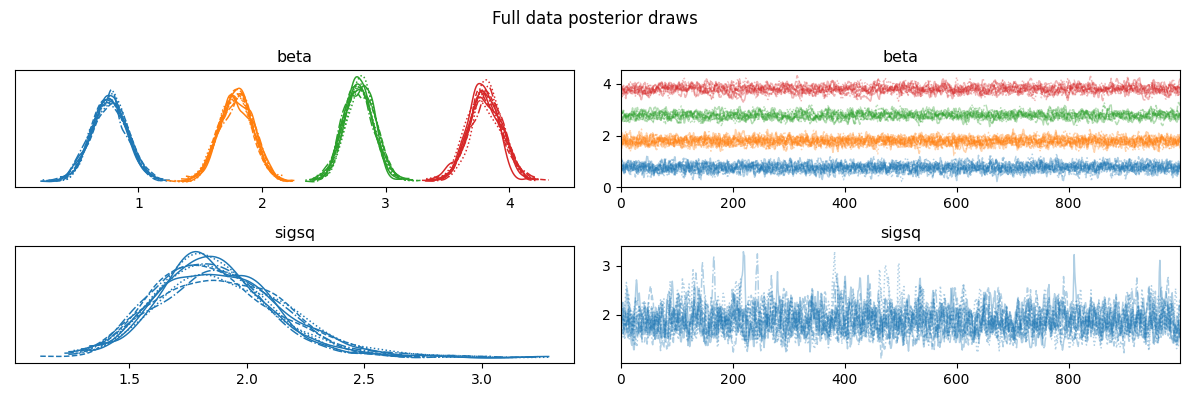

In [16]:
trace_az = az.convert_to_inference_data(dict(beta=trace.position.beta, sigsq=jax.vmap(sigsq_t.forward)(trace.position.sigsq)))
az.plot_trace(trace_az)
plt.suptitle('Full data posterior draws')
plt.tight_layout()

In [17]:
%%time

def make_fold(fold_id):
    results = fold_posterior(
        prng_key=inference_key,
        inference_loop=online_inference_loop,
        logjoint_density=lambda theta: logjoint_density(theta, fold_id),
        log_p=lambda theta: log_pred(theta, fold_id),
        make_initial_pos=make_initial_pos,
        num_chains=10,
        num_samples=2000,
        warmup_iter=1000)
    return results

online_fold_states = jax.vmap(make_fold)(jnp.arange(5))

CPU times: user 6.44 s, sys: 45.4 ms, total: 6.48 s
Wall time: 6.44 s


In [18]:
estimate_elpd(online_fold_states)

-177.5559844970703

In [19]:
rhat_summary(online_fold_states)

fold            measure   beta[0]   beta[1]   beta[2]   beta[3]  \
0      Fold 0         Split Rhat  1.004729  1.003090  1.001378  1.001638   
1      Fold 0  Folded Split Rhat  1.000225  1.000344  1.000089  0.999989   
2      Fold 1         Split Rhat  1.004235  1.003935  1.003002  1.001966   
3      Fold 1  Folded Split Rhat  1.000123  1.000396  1.000308  1.000800   
4      Fold 2         Split Rhat  1.005523  1.002380  1.002399  1.001968   
5      Fold 2  Folded Split Rhat  0.999975  1.000386  1.000471  1.000957   
6      Fold 3         Split Rhat  1.004545  1.002787  1.003509  1.001956   
7      Fold 3  Folded Split Rhat  1.000243  1.000529  1.000519  1.000468   
8      Fold 4         Split Rhat  1.005509  1.006385  1.002367  1.001395   
9      Fold 4  Folded Split Rhat  1.000622  1.000551  1.000358  1.000391   
10  All folds                Max  1.005523  1.006385  1.003509  1.001968   

       sigsq     log p  
0   1.002931  1.002030  
1   1.000200  1.002030  
2   1.004068  1.005659  
3   1.000540  1.005659  
4   1.008226  1.007498  
5   1.001552  1.007498  
6   1.004012  1.003799  
7   1.001490  1.003799  
8   1.003474  1.004780  
9   1.000513  1.004780  
10  1.008226  1.007498

## Offline inference replay

In [23]:
def replay_fold(fold_id, inference_key=inference_key):
    results, trace = fold_posterior(
        prng_key=inference_key,
        inference_loop=offline_inference_loop,
        logjoint_density=lambda theta: logjoint_density(theta, fold_id),
        log_p=lambda theta: log_pred(theta, fold_id),
        make_initial_pos=make_initial_pos,
        num_chains=10,
        num_samples=2000,
        warmup_iter=1000)
    pos = trace.position
    theta_dict = az.convert_to_inference_data(dict(beta=pos.beta, sigsq=jax.vmap(sigsq_t.forward)(pos.sigsq)))
    trace_az = az.convert_to_inference_data(theta_dict)
    return results, trace_az

In [24]:
fold4_state, fold4_trace = replay_fold(4)

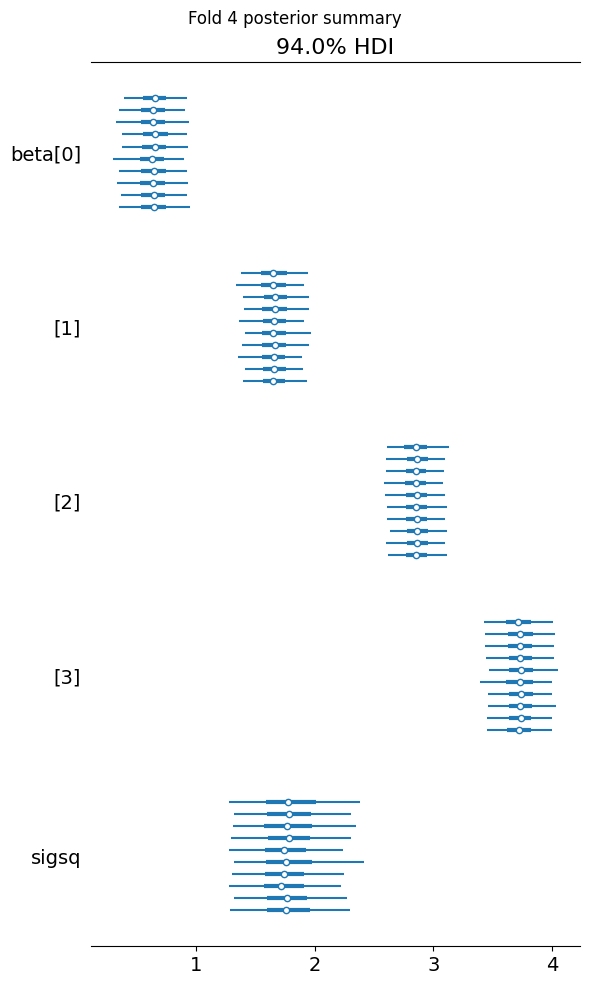

In [30]:
az.plot_forest(fold4_trace)
plt.suptitle(f"Fold 4 posterior summary")
plt.tight_layout()

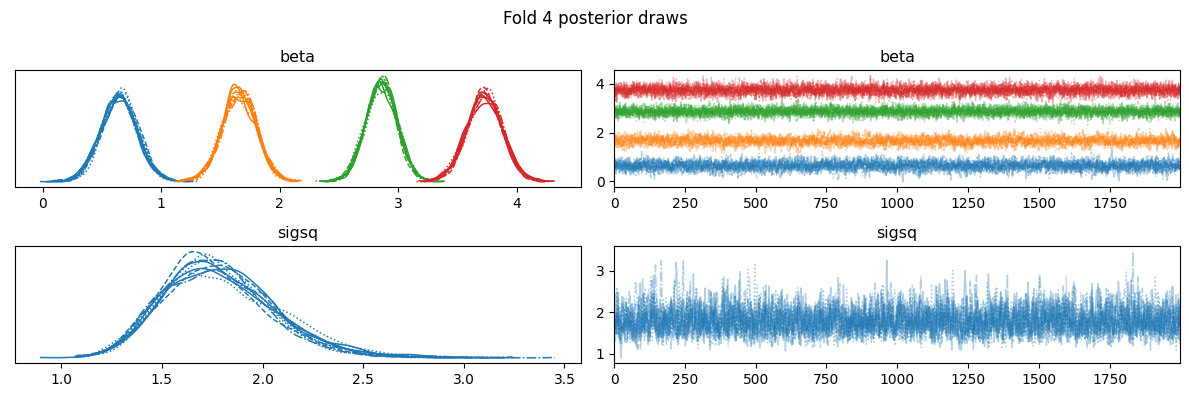

In [27]:
az.plot_trace(fold4_trace);
plt.suptitle('Fold 4 posterior draws')
plt.tight_layout()